# Line Background Estimation Using Adjacent Energy Bins

H.Yoneda, S. Mittal

This is a tutorial notebook on background estimation for gamma-ray lines.
The basic idea is as follows:
- Extracting the event distribution in the Compton data space from adjacent energy bins of the energy of interest.
- Making a binned histogram using the extracted events.
- Estimate the total number of expected background counts in the line energy bin by fitting the adjacent energy bin data, and modify the normalization of the binned histogram accordingly.

Here, we make a background model for Al-26. These processes will be performed in the `LineBackgroundEstimation` class, and you can see how it works as follows.

This class is very preliminary, and there are several areas for improvement. Future ideas include:
- We may add more options in the minuit fitting, e.g., limiting the parameter region, fixing some parameters.
- We may apply smoothing to the background histogram, which may help to mitigate Poisson fluctuation in the model.

In [1]:
import logging
import sys
logger = logging.getLogger('cosipy')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [3]:
from histpy import Histogram, Axis, Axes
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate
from iminuit import Minuit
from cosipy import BinnedData, LineBackgroundEstimation

# 0. Create dataset for the line background estimation

We need an event histogram binned finely along the energy axis.

In [4]:
#need to change them
path_to_Al  = "path/to/data"
path_to_bkg = "path/to/data"

In [5]:
#yaml files containing binning information
spectrum_bkg = BinnedData("inputs_bkg_estimation.yaml")
spectrum_Al = BinnedData("inputs_bkg_estimation.yaml")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


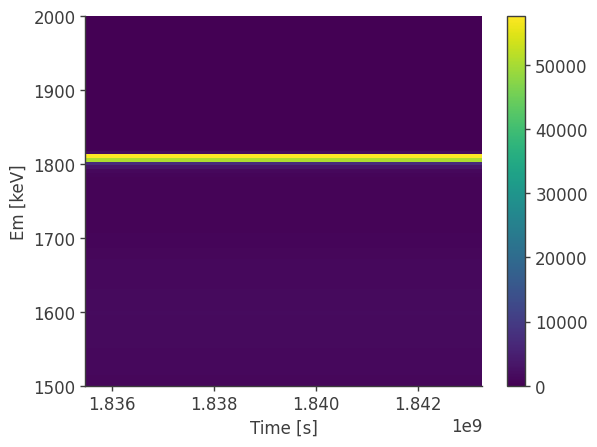

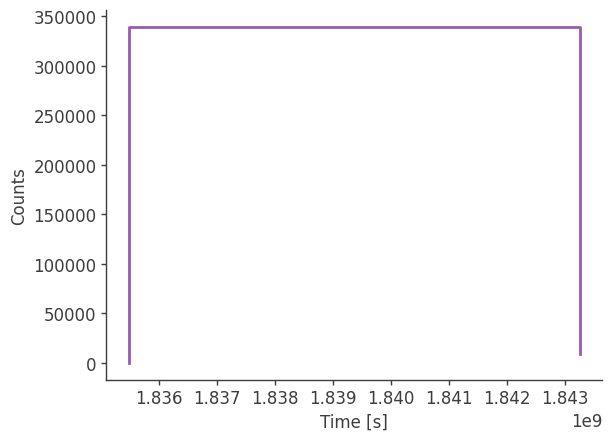

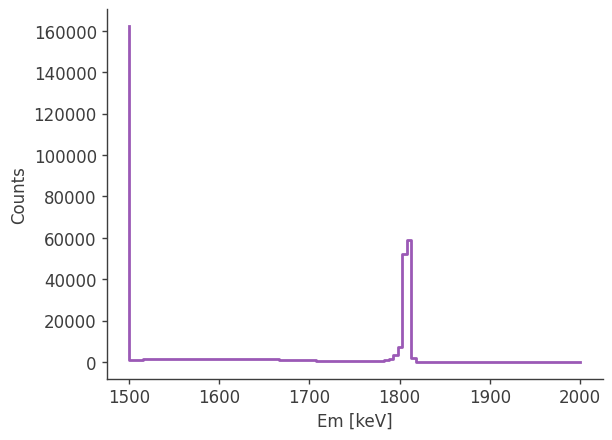

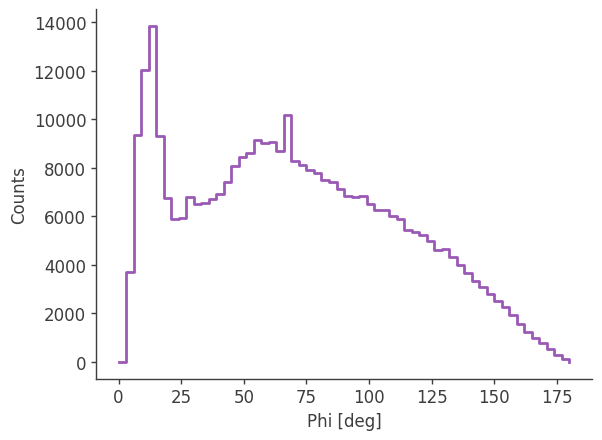

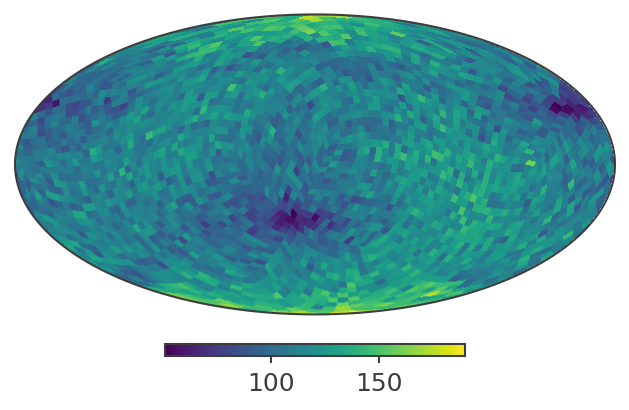

plotting psichi in Galactic coordinates...


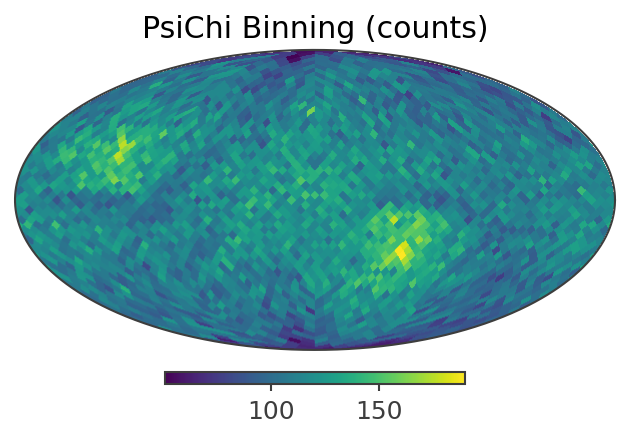

CPU times: user 6.48 s, sys: 1.73 s, total: 8.21 s
Wall time: 4.5 s


In [6]:
%%time

#path to unbinned fits file for source and background to create binned dataset
spectrum_Al.get_binned_data(unbinned_data=path_to_Al, make_binning_plots=True, 
            output_name='Al_binned', show_plots=True)

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


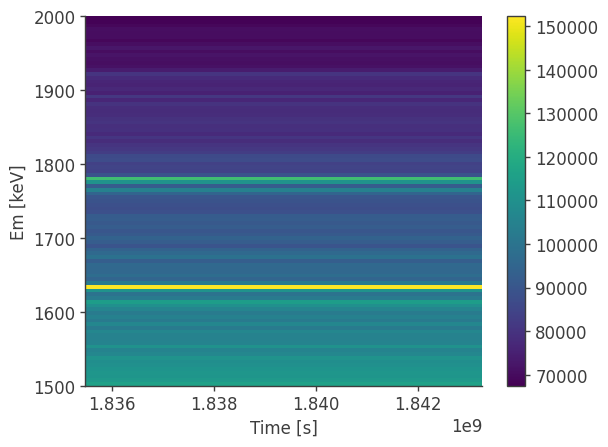

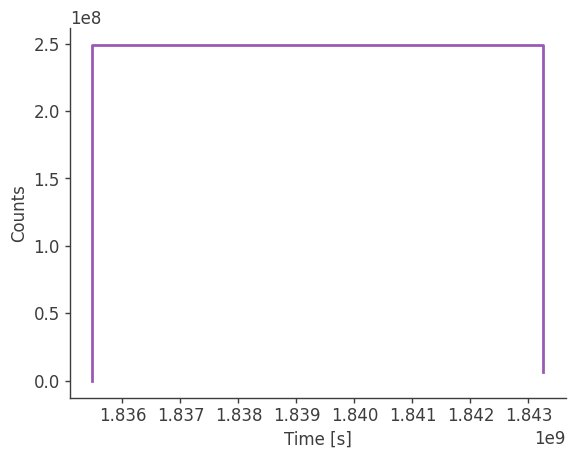

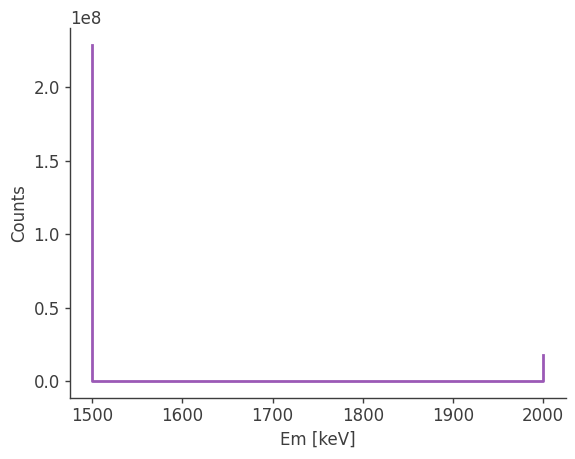

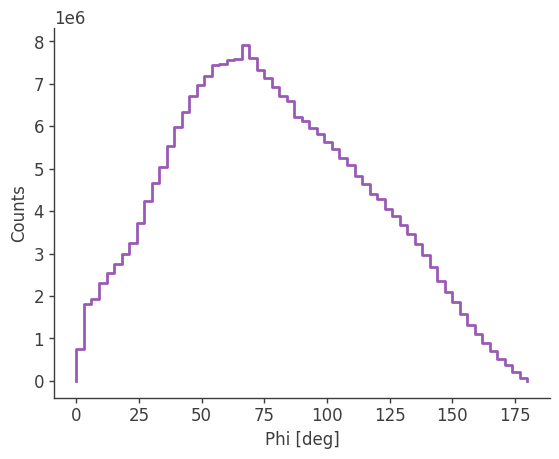

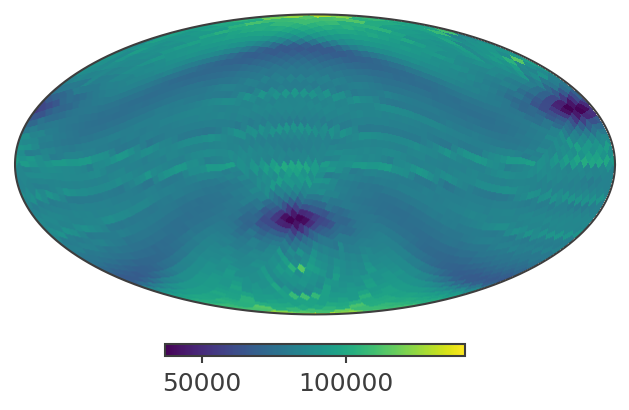

plotting psichi in Galactic coordinates...


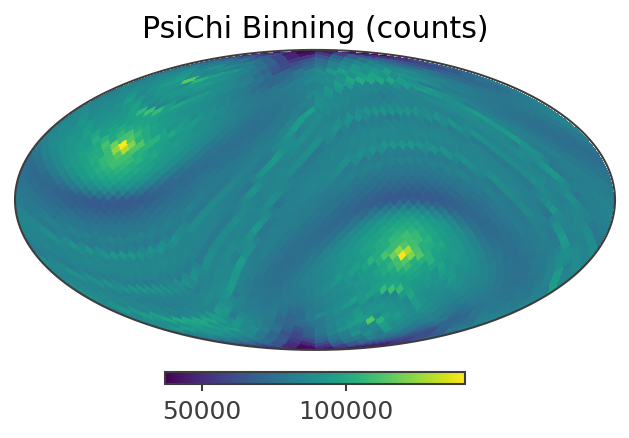

CPU times: user 10min 9s, sys: 46.7 s, total: 10min 56s
Wall time: 11min 53s


In [7]:
%%time

#path to unbinned fits file for source and background to create binned dataset
spectrum_bkg.get_binned_data(unbinned_data=path_to_bkg, make_binning_plots=True, 
            output_name='bkg_binned', show_plots=True)

In [8]:
#combine source and background binned data
spectrum_total = spectrum_Al.binned_data + spectrum_bkg.binned_data
spectrum_total.write('combined_al_bkg_nside_16.hdf5')

This `spectrum_total` can be considered as the actual event histogram in COSI observations.

In [9]:
# load data
spectrum_bkg = Histogram.open("bkg_binned.hdf5")
spectrum_Al = Histogram.open("Al_binned.hdf5")
spectrum_total = Histogram.open("combined_al_bkg_nside_16.hdf5")

# 1. Instantiate the LineBackgroundEstimation

In [10]:
instance = LineBackgroundEstimation(spectrum_total)

# 2. Set background model and fit it

## Define a background spectrum model for fitting data

In [11]:
def powerlaw(x, a, b, pivot):
    return a * (x/pivot)**b

def gaussian(x, a, mu, sigma):
    return a / (sigma) / np.sqrt(2 * np.pi) * np.exp( -(x-mu)**2 / (2*sigma**2))

def bkg_model(x, a, b, a1, mu1, a2, mu2, a3, mu3, a4, mu4, sigma):
    pivot = 1800.0
    return powerlaw(x,a,b, pivot) + \
            gaussian(x , a1, mu1, sigma) + \
            gaussian(x , a2, mu2, sigma) + \
            gaussian(x , a3, mu3, sigma) + \
            gaussian(x , a4, mu4, sigma)

(<AxesSubplot: xlabel='Em [keV]'>, <ErrorbarContainer object of 3 artists>)

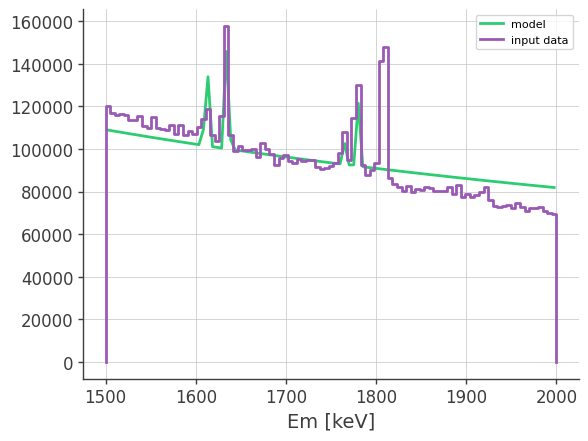

In [12]:
instance.set_bkg_energy_spectrum_model(bkg_model, [18000.0, -1.0, 40000.0, 1612, 50000.0, 1635, 10000.0, 1765, 30000.0, 1780, 1.0])
instance.plot_energy_spectrum()

In [13]:
%%time

m = instance.fit_energy_spectrum()
m

CPU times: user 13.3 s, sys: 134 ms, total: 13.4 s
Wall time: 13.5 s


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.903e+07                 │             Nfcn = 1301              │
│ EDM = 0.000496 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 17.385e3  │  0.007e3  │            │            │         │         │       │
│ 1 │ x1   │  -1.702   │   0.004   │            │            │         │         │       │
│ 2 │ x2   │  21.7e3   │   0.5e3   │            │            │         │         │       │
│ 3 │ x3   │ 1.61183e3 │ 0.00007e3 │            │            │         │         │       │
│ 4 │ x4   │  71.7e3   │   0.6e3   │            │            │         │         │       │
│ 5 │ x5   │1.633315e3 │0.000034e3 │            │            │         │         │       │
│ 6 │ x6   │  24.8e3   │   0.5e3   │            │            │         │         │       │
│ 7 │ x7   │ 1.76410e3 │ 0.00009e3 │            │            │         │         │       │
│ 8 │ x8   │  67.2e3   │   0.5e3   │            │            │         │         │       │
│ 9 │ x9   │1.778490e3 │0.000025e3 │            │            │         │         │       │
│ 10│ x10  │   2.136   │   0.027   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10 │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │      45.1    0.0114      -340  -0.00406      -633  -0.00999      -518  -0.00803      -596  -0.00841   -0.0285 │
│  x1 │    0.0114  1.62e-05      0.26 -5.46e-06     0.256  2.73e-07   -0.0368  9.05e-06    -0.053  3.11e-06  6.46e-06 │
│  x2 │      -340      0.26  2.54e+05     -5.79  3.04e+04     0.693  1.02e+04      1.68   1.3e+04     0.703      1.78 │
│  x3 │  -0.00406 -5.46e-06     -5.79    0.0051      3.42  0.000128     0.926   0.00031      1.42  0.000118  0.000283 │
│  x4 │      -633     0.256  3.04e+04      3.42   3.9e+05      1.89  3.78e+04      9.94  5.38e+04      3.87      9.45 │
│  x5 │  -0.00999  2.73e-07     0.693  0.000128      1.89   0.00113      1.15  0.000352      1.71  0.000135  0.000325 │
│  x6 │      -518   -0.0368  1.02e+04     0.926  3.78e+04      1.15   2.2e+05     -7.56  1.86e+04      1.06      2.67 │
│  x7 │  -0.00803  9.05e-06      1.68   0.00031      9.94  0.000352     -7.56   0.00764      3.85  0.000342  0.000787 │
│  x8 │      -596    -0.053   1.3e+04      1.42  5.38e+04      1.71  1.86e+04      3.85  2.79e+05    0.0919      3.92 │
│  x9 │  -0.00841  3.11e-06     0.703  0.000118      3.87  0.000135      1.06  0.000342    0.0919  0.000647  0.000303 │
│ x10 │   -0.0285  6.46e-06      1.78  0.000283      9.45  0.000325      2.67  0.000787      3.92  0.000303  0.000733 │
└─────┴────────────────────────────────────

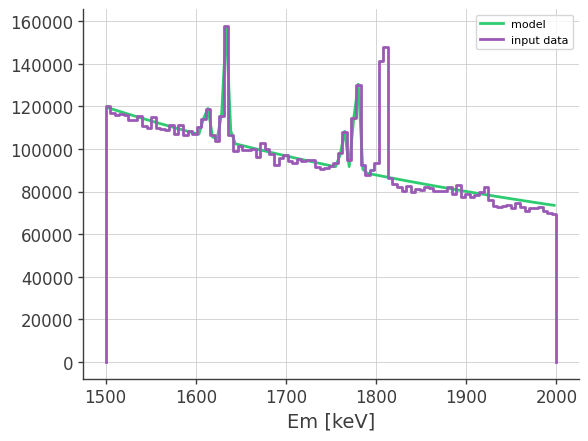

In [14]:
ax, _ = instance.plot_energy_spectrum()

## Mask a region around Al-26

In [15]:
instance.set_mask((1790.0, 1825.0) * u.keV)
instance.mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [16]:
m = instance.fit_energy_spectrum()
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.049e+07                 │              Nfcn = 796              │
│ EDM = 0.00093 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 17.041e3  │  0.007e3  │            │            │         │         │       │
│ 1 │ x1   │  -1.797   │   0.004   │            │            │         │         │       │
│ 2 │ x2   │  24.3e3   │   0.5e3   │            │            │         │         │       │
│ 3 │ x3   │ 1.61187e3 │ 0.00007e3 │            │            │         │         │       │
│ 4 │ x4   │  76.4e3   │   0.6e3   │            │            │         │         │       │
│ 5 │ x5   │1.633376e3 │0.000030e3 │            │            │         │         │       │
│ 6 │ x6   │  28.9e3   │   0.5e3   │            │            │         │         │       │
│ 7 │ x7   │ 1.76417e3 │ 0.00008e3 │            │            │         │         │       │
│ 8 │ x8   │  72.0e3   │   0.5e3   │            │            │         │         │       │
│ 9 │ x9   │1.778556e3 │0.000027e3 │            │            │         │         │       │
│ 10│ x10  │   2.348   │   0.024   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10 │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │      50.2    0.0131      -412   -0.0058      -712  -0.00677      -632   -0.0117      -736   -0.0103   -0.0312 │
│  x1 │    0.0131  1.69e-05     0.255 -5.48e-06     0.223 -6.66e-07   -0.0593  5.37e-06     -0.08  1.97e-06  3.81e-06 │
│  x2 │      -412     0.255  2.64e+05     -4.68  3.43e+04     0.476  1.47e+04      1.76  1.89e+04     0.832      2.03 │
│  x3 │   -0.0058 -5.48e-06     -4.68   0.00545      2.68  6.14e-05      1.07  0.000222      1.58  9.67e-05  0.000226 │
│  x4 │      -712     0.223  3.43e+04      2.68  3.82e+05     0.687  4.31e+04      7.12  5.98e+04      3.19      7.57 │
│  x5 │  -0.00677 -6.66e-07     0.476  6.14e-05     0.687  0.000903     0.787  0.000152      1.14  6.68e-05  0.000157 │
│  x6 │      -632   -0.0593  1.47e+04      1.07  4.31e+04     0.787  2.33e+05     -4.58  2.75e+04      1.28      3.05 │
│  x7 │   -0.0117  5.37e-06      1.76  0.000222      7.12  0.000152     -4.58   0.00701       3.7  0.000285   0.00057 │
│  x8 │      -736     -0.08  1.89e+04      1.58  5.98e+04      1.14  2.75e+04       3.7  2.98e+05     0.609      4.37 │
│  x9 │   -0.0103  1.97e-06     0.832  9.67e-05      3.19  6.68e-05      1.28  0.000285     0.609  0.000704  0.000251 │
│ x10 │   -0.0312  3.81e-06      2.03  0.000226      7.57  0.000157      3.05   0.00057      4.37  0.000251  0.000591 │
└─────┴────────────────────────────────────

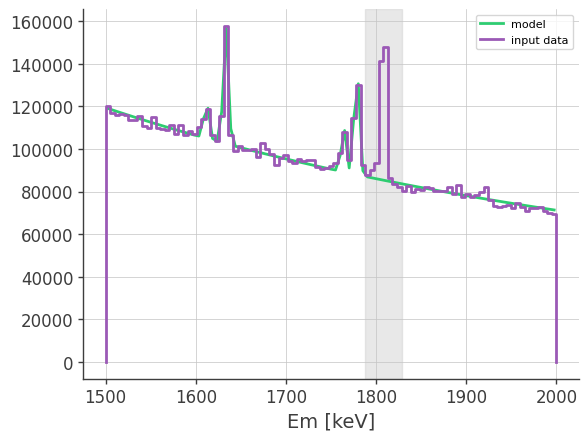

In [17]:
ax, _ = instance.plot_energy_spectrum()

## Mask more

In [18]:
instance.set_mask((1790.0, 1825.0) * u.keV, (1500.0, 1600.0) * u.keV, (1950.0, 2000.0) * u.keV)
instance.mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [19]:
m = instance.fit_energy_spectrum()
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.934e+07                 │              Nfcn = 749              │
│ EDM = 0.000125 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 17.119e3  │  0.008e3  │            │            │         │         │       │
│ 1 │ x1   │  -1.816   │   0.008   │            │            │         │         │       │
│ 2 │ x2   │  22.6e3   │   0.6e3   │            │            │         │         │       │
│ 3 │ x3   │ 1.61187e3 │ 0.00008e3 │            │            │         │         │       │
│ 4 │ x4   │  74.1e3   │   0.6e3   │            │            │         │         │       │
│ 5 │ x5   │1.633359e3 │0.000031e3 │            │            │         │         │       │
│ 6 │ x6   │  27.6e3   │   0.5e3   │            │            │         │         │       │
│ 7 │ x7   │ 1.76412e3 │ 0.00008e3 │            │            │         │         │       │
│ 8 │ x8   │  70.5e3   │   0.5e3   │            │            │         │         │       │
│ 9 │ x9   │1.778525e3 │0.000026e3 │            │            │         │         │       │
│ 10│ x10  │   2.262   │   0.025   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10 │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │        71    0.0159      -625  -0.00106 -1.02e+03  -0.00659      -877   -0.0042      -997   -0.0128   -0.0433 │
│  x1 │    0.0159  6.35e-05      1.47 -3.95e-05      1.52 -9.89e-07     0.248  2.65e-05     0.223  1.67e-05  4.11e-05 │
│  x2 │      -625      1.47  3.03e+05     -9.59  6.97e+04     0.343  2.46e+04      1.78  2.79e+04      1.14       2.9 │
│  x3 │  -0.00106 -3.95e-05     -9.59   0.00588      2.21  6.56e-05      0.92  0.000226      1.43  0.000108  0.000248 │
│  x4 │ -1.02e+03      1.52  6.97e+04      2.21  4.18e+05       0.1  5.47e+04      6.79  6.89e+04      3.68      8.92 │
│  x5 │  -0.00659 -9.89e-07     0.343  6.56e-05       0.1  0.000939      0.66  0.000118     0.916  5.92e-05  0.000139 │
│  x6 │      -877     0.248  2.46e+04      0.92  5.47e+04      0.66  2.36e+05     -6.66  3.06e+04      1.35      3.36 │
│  x7 │   -0.0042  2.65e-05      1.78  0.000226      6.79  0.000118     -6.66   0.00686      3.06  0.000253  0.000524 │
│  x8 │      -997     0.223  2.79e+04      1.43  6.89e+04     0.916  3.06e+04      3.06  2.97e+05     0.267      4.48 │
│  x9 │   -0.0128  1.67e-05      1.14  0.000108      3.68  5.92e-05      1.35  0.000253     0.267  0.000676  0.000271 │
│ x10 │   -0.0433  4.11e-05       2.9  0.000248      8.92  0.000139      3.36  0.000524      4.48  0.000271  0.000643 │
└─────┴────────────────────────────────────

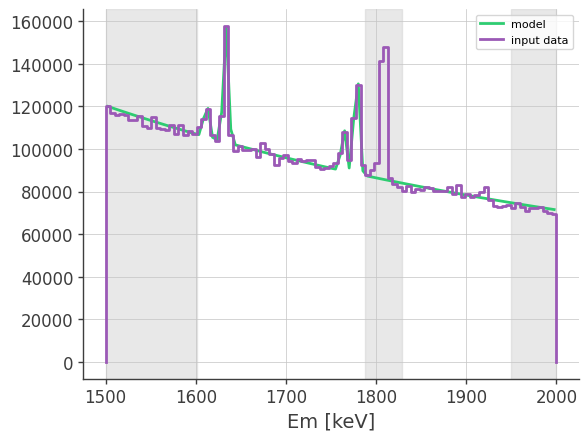

In [20]:
ax, _ = instance.plot_energy_spectrum()

# 3. Generate Background Histogram

In [21]:
source_range = (1805, 1812)  * u.keV #counts estimation in Al26 line

background_region_1 = (1650, 1750) * u.keV #background counts estimation before the line
background_region_2 = (1850, 1950) * u.keV #background counts estimation before the line

In [22]:
bkg_model_histogram = instance.generate_bkg_model_histogram(source_range, [background_region_1, background_region_2])

The energy range [1650. 1750.] is modified to [1646.46464646, 1747.47474747]
The energy range [1850. 1950.] is modified to [1848.48484848, 1949.49494949]


In [23]:
bkg_model_histogram.write('bkg_model_al26_line.hdf5', overwrite=True)

# 4. Compare the background model with the actual background data

In [24]:
%%time

bkg_histogram_in_Al26line = BinnedData("inputs_check_results.yaml")
bkg_histogram_in_Al26line.get_binned_data(unbinned_data=path_to_bkg, make_binning_plots=False, 
                                          output_name='bkg_data_al26_line_for_comparison', show_plots=False)

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
CPU times: user 9min 42s, sys: 43.6 s, total: 10min 26s
Wall time: 11min 21s


In [27]:
bkg_histogram_in_Al26line = Histogram.open("bkg_data_al26_line_for_comparison.hdf5")

In [38]:
bkg_model_histogram = bkg_model_histogram.todense()
bkg_histogram_in_Al26line = bkg_histogram_in_Al26line.todense()

In [39]:
bkg_model_histogram.clear_underflow_and_overflow()
bkg_histogram_in_Al26line.clear_underflow_and_overflow()

## Normalization

In [40]:
count_model = np.sum(bkg_model_histogram[:])
count_obs = np.sum(bkg_histogram_in_Al26line[:])

print("model:", count_model)
print("data:", count_obs)
print("difference:", (count_obs/count_model - 1)*1e2, "%")

model: 121060.00652583277
data: 121530.0
difference: 0.3882318262282025 %


## Phi distritbuion

In [41]:
bkg_model_phi = bkg_model_histogram.project("Phi").todense()
bkg_obs_phi = bkg_histogram_in_Al26line.project("Phi").todense()

(-20.0, 20.0)

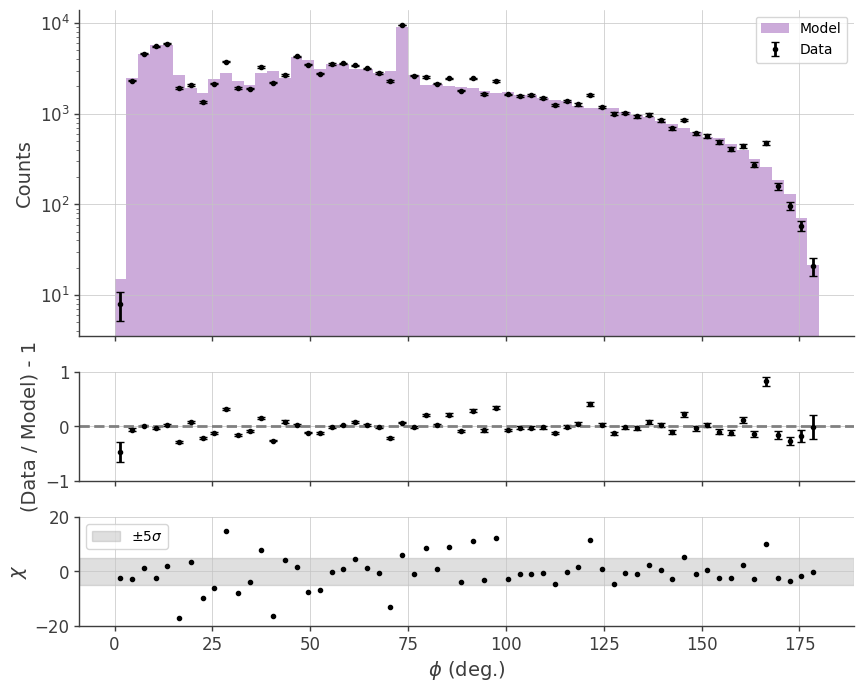

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

ax3.set_xlabel(r'$\phi$ (deg.)')

ax1.bar(bkg_model_phi.axis.centers, bkg_model_phi.contents, width = 3, alpha=0.5, label='Model')
#ax1.bar(bkg_obs_phi.axis.centers,   bkg_obs_phi.contents,   width = 3, alpha=0.5, label='Data', capsize=3, yerr = np.sqrt(bkg_obs_phi.contents))
ax1.errorbar(bkg_obs_phi.axis.centers, bkg_obs_phi.contents, color = 'black', label='Data', fmt='.', capsize=3, yerr = np.sqrt(bkg_obs_phi.contents))
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 10)
ax1.grid()
ax1.set_yscale('log')

# ratio
diff = bkg_obs_phi.contents / bkg_model_phi.contents - 1
diff_err = np.sqrt(bkg_obs_phi.contents) / bkg_model_phi.contents
ax2.errorbar(bkg_model_phi.axis.centers, diff, yerr=diff_err, fmt='.', capsize=3, color = 'black')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
ax2.grid()
ax2.set_ylabel('(Data / Model) - 1')
ax2.set_ylim(-1, 1)

# chi
xi = (bkg_obs_phi.contents - bkg_model_phi.contents) / np.sqrt(bkg_obs_phi.contents)
ax3.plot(bkg_model_phi.axis.centers, xi, '.', color = 'black')
ax3.axhspan(-5, 5, color = 'grey', alpha = 0.25, label = r"$\pm 5 \sigma$")
ax3.set_ylabel(r"$\chi$")
ax3.grid()
ax3.legend(fontsize = 10)
ax3.set_ylim(-20, 20)

## PsiChi distritbuion

In [44]:
bkg_model_psichi = bkg_model_histogram.project("PsiChi")
bkg_obs_psichi = bkg_histogram_in_Al26line.project("PsiChi")

(-10.0, 10.0)

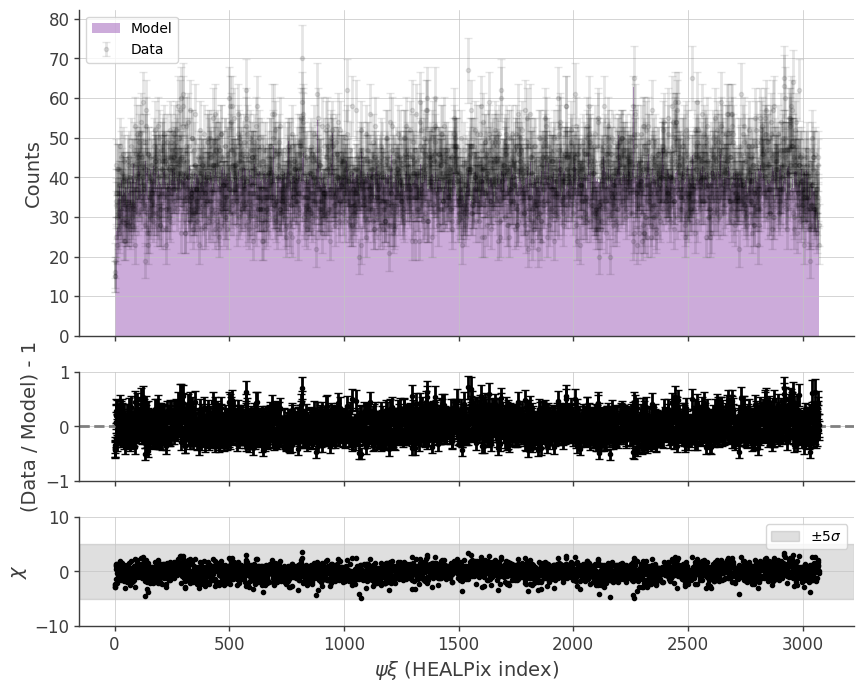

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

ax3.set_xlabel(r'$\psi \xi$ (HEALPix index)')

ax1.bar(bkg_model_psichi.axis.centers, bkg_model_psichi.contents, width = 1, alpha=0.5, label='Model')
#ax1.bar(bkg_obs_psichi.axis.centers,   bkg_obs_psichi.contents,   width = 3, alpha=0.5, label='Data')#, capsize=3, yerr = np.sqrt(bkg_obs_psichi.contents))
ax1.errorbar(bkg_obs_psichi.axis.centers, bkg_obs_psichi.contents, color = 'black', alpha=0.1, label='Data', fmt='.', capsize=3, yerr = np.sqrt(bkg_obs_psichi.contents))
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 10)
ax1.grid()
#ax1.set_yscale('log')

# ratio
diff = bkg_obs_psichi.contents / bkg_model_psichi.contents - 1
diff_err = np.sqrt(bkg_obs_psichi.contents) / bkg_model_psichi.contents
ax2.errorbar(bkg_model_psichi.axis.centers, diff, yerr=diff_err, fmt='.', capsize=3, color = 'black')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
ax2.grid()
ax2.set_ylabel('(Data / Model) - 1')
ax2.set_ylim(-1, 1)

# chi
xi = (bkg_obs_psichi.contents - bkg_model_psichi.contents) / np.sqrt(bkg_obs_psichi.contents)
ax3.plot(bkg_model_psichi.axis.centers, xi, '.', color = 'black')
ax3.axhspan(-5, 5, color = 'grey', alpha = 0.25, label = r"$\pm 5 \sigma$")
ax3.set_ylabel(r"$\chi$")
ax3.grid()
ax3.legend(fontsize = 10)
ax3.set_ylim(-10, 10)

### Rebinning

In [47]:
import healpy as hp

In [48]:
nside_out = 4

bkg_model_psichi_rebinned = hp.ud_grade(bkg_model_psichi[:], nside_out, power = -2)
bkg_obs_psichi_rebinned   = hp.ud_grade(bkg_obs_psichi[:],   nside_out, power = -2)

(-10.0, 10.0)

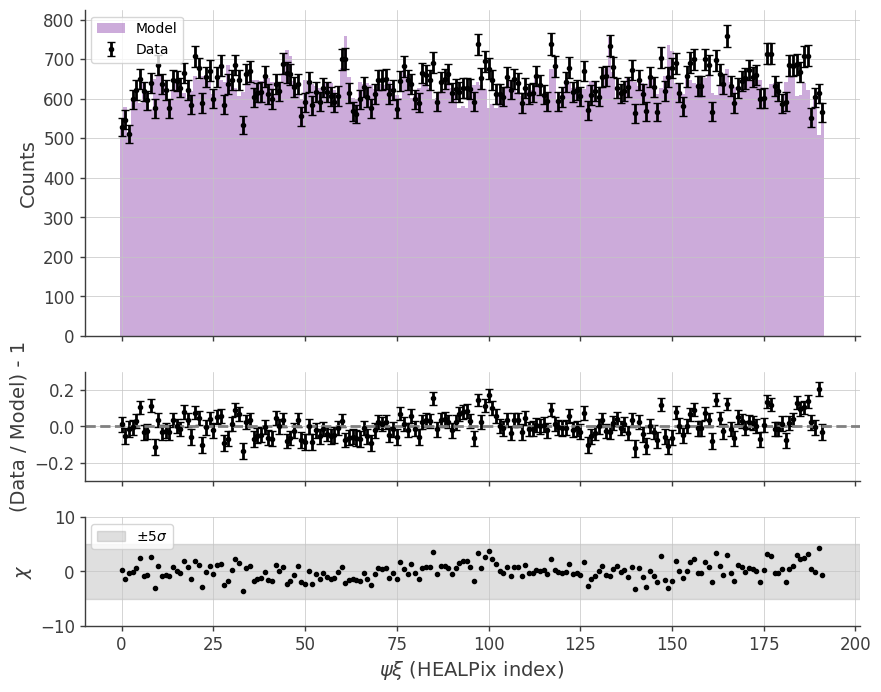

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

ax3.set_xlabel(r'$\psi \xi$ (HEALPix index)')

ax1.bar(np.arange(hp.nside2npix(nside_out)), bkg_model_psichi_rebinned, width = 1, alpha=0.5, label='Model')
#ax1.bar(np.arange(hp.nside2npix(nside_out)), bkg_obs_psichi_rebinned,   width = 3, alpha=0.5, label='Data', capsize=3, yerr = np.sqrt(bkg_obs_psichi_rebinned))
ax1.errorbar(np.arange(hp.nside2npix(nside_out)), bkg_obs_psichi_rebinned, color = 'black', alpha=1, label='Data', fmt='.', capsize=3, yerr = np.sqrt(bkg_obs_psichi_rebinned))
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 10)
ax1.grid()
#ax1.set_yscale('log')

# ratio
diff = bkg_obs_psichi_rebinned / bkg_model_psichi_rebinned - 1
diff_err = np.sqrt(bkg_model_psichi_rebinned) / bkg_obs_psichi_rebinned
ax2.errorbar(np.arange(hp.nside2npix(nside_out)), diff, yerr=diff_err, fmt='.', capsize=3, color = 'black')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
ax2.grid()
ax2.set_ylabel('(Data / Model) - 1')
ax2.set_ylim(-0.3, 0.3)

# chi
xi = (bkg_obs_psichi_rebinned - bkg_model_psichi_rebinned) / np.sqrt(bkg_obs_psichi_rebinned)
ax3.plot(np.arange(hp.nside2npix(nside_out)), xi, '.', color = 'black')
ax3.axhspan(-5, 5, color = 'grey', alpha = 0.25, label = r"$\pm 5 \sigma$")
ax3.set_ylabel(r"$\chi$")
ax3.grid()
ax3.legend(fontsize = 10)
ax3.set_ylim(-10, 10)

As an future idea, applying the smoothing to the background model would be useful to mitigate the Poisson fluctutation in the backgroud model. Note that the smoothing also loses high-frequency information, so there should be optimized in some ways.

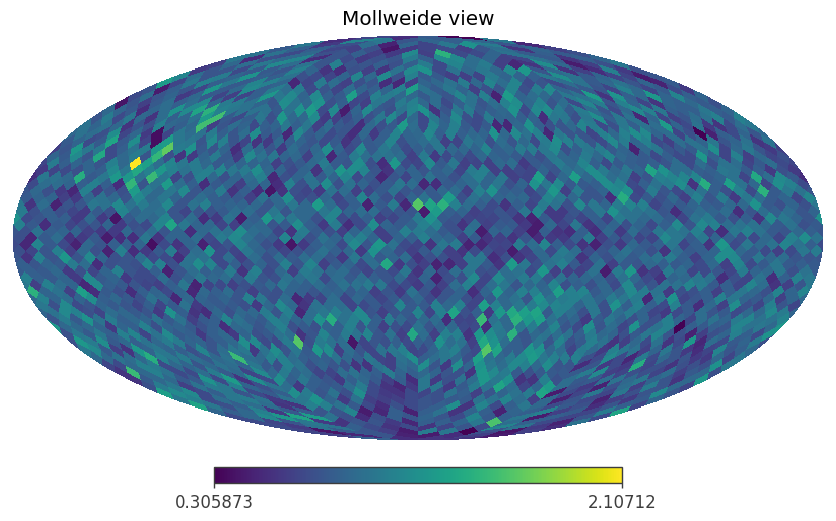

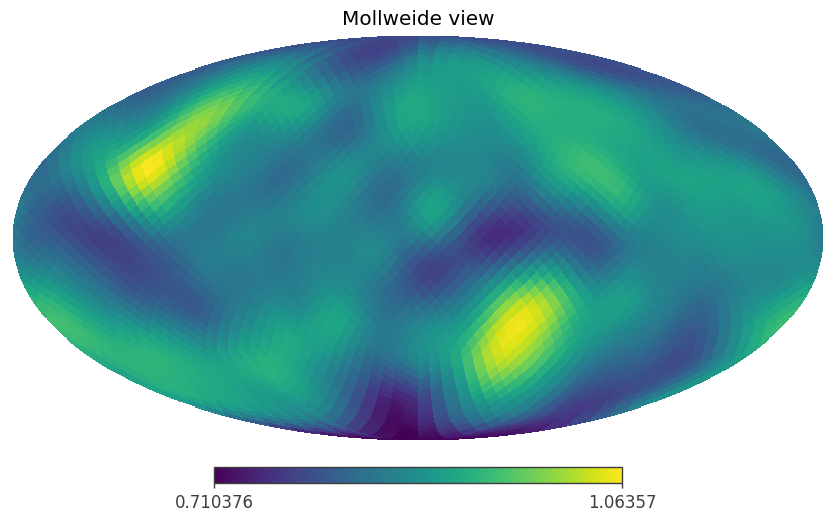

In [50]:
sliced_bkg_map = bkg_model_histogram[0,0,25]

hp.mollview(sliced_bkg_map)

sliced_smoothed_bkg_map = hp.smoothing(sliced_bkg_map, fwhm = (20.0 * u.deg).to('rad').value)

hp.mollview(sliced_smoothed_bkg_map)